In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask import Flask, jsonify
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

for x in Measurement.__table__.columns.keys():
    print (x)


id
station
date
prcp
tobs


In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
#Query to get the date of last result
LatestDate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()


#coversion of result to DATETIME
LatestDate=datetime.strptime(LatestDate[0], '%Y-%m-%d')

#Date 12 months ago
yr_ago = LatestDate - dt.timedelta(days=365)
yr_ago

datetime.datetime(2016, 8, 23, 0, 0)

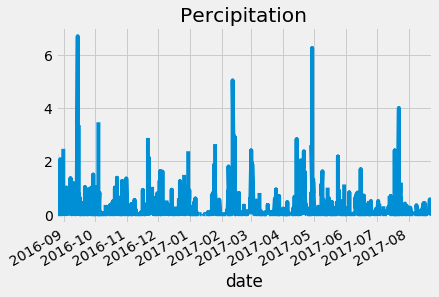

In [47]:
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
results = session.query(Measurement.date
                        , Measurement.id
                        , Measurement.station
                        , Measurement.prcp
                        ,Measurement.tobs
                       ).filter(Measurement.date >= yr_ago).all()
Measurementdf=pd.DataFrame(results)
Measurementdf["date"]= pd.to_datetime(Measurementdf["date"])
Measurementdf=Measurementdf.set_index('date')
Measurementdf["prcp"].plot(title ="Percipitation")

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statSummary=pd.DataFrame(Measurementdf["prcp"].describe())
statSummary

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [50]:
# Design a query to show how many stations are available in this dataset?

stations=(session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
     ).order_by(Measurement.station).count()

print (f" There are {stations} stations in the dataset." )


 There are 9 stations in the dataset.


In [52]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#most active station

activeStation= (session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
     ).order_by(func.count(Measurement.station).desc()).first()

print(f"The most active station is {activeStation[0]} with {activeStation[1]} records.")

activeStations=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station) .\
     order_by(func.count(Measurement.station).desc()).all()

activeStations[0]

The most active station is USC00519281 with 2772 records.


('USC00519281', 2772)

In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#station281 = session.query(Measurement.tobs).filter(Measurement.station == activeStation[0]).all()
#station281

station281 = session.query(func.max(Measurement.tobs).label("Max Temp")
                           ,func.avg(Measurement.tobs).label("Avg Temp") 
                           ,func.min(Measurement.tobs).label("Min Temp")
                ).filter(Measurement.station == activeStation[0]).all()

max_temp=station281[0][0]
Avg_temp=station281[0][1]
Min_temp=station281[0][2]

stationDF=pd.DataFrame(station281)


print(f" The highest temperature recorded by station {activeStation[0]} is {max_temp} degrees ,\n  the average temperature is {round(Avg_temp)}, and the lowest temperture is {Min_temp}"  )

stationDF



 The highest temperature recorded by station USC00519281 is 85.0 degrees ,
  the average temperature is 72, and the lowest temperture is 54.0


,Max Temp,Avg Temp,Min Temp
0,85.0,71.663781,54.0


The station with the highest number of temperature observations is USC00519281 with 2772 records.


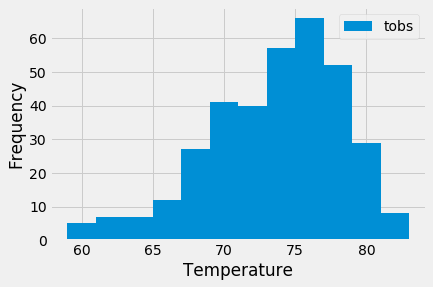

In [55]:
# Choose the station with the highest number of temperature observations.
TempStation= (session.query(Measurement.station, func.count(Measurement.tobs))
    .group_by(Measurement.station)
     ).order_by(func.count(Measurement.tobs).desc()).first()


print(f"The station with the highest number of temperature observations is {TempStation[0]} with {TempStation[1]} records.")
TempStation

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Tempresults = session.query(Measurement.date
                            ,Measurement.station
                            ,Measurement.tobs).filter(Measurement.date >= yr_ago
                                                      , Measurement.station==TempStation[0]).all()


x=[x[2]for x in Tempresults]

plt.hist(x, bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="best")



In [56]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [58]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#date of trip = 2016-02-10 to 2016-02-20

vacTemp=calc_temps('2016-02-10', '2016-02-20')
vacTemp

[(58.0, 70.83098591549296, 79.0)]

Text(0.5, 0, 'Average Temperatures')

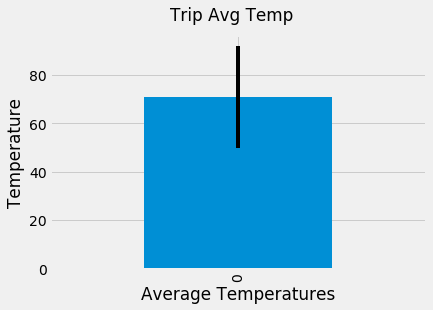

In [62]:
#Turning vacation data to a dataframe
vacation=pd.DataFrame(vacTemp,columns=['TMIN', 'TAVE', 'TMAX'])

# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y=[vacation["TAVE"]]
standard_errors=[vacation["TMAX"]-vacation["TMIN"]]

fig, ax = plt.subplots()
vacation["TAVE"].plot.bar(yerr=standard_errors)
fig.suptitle("Trip Avg Temp")
ax.set_ylabel("Temperature")
ax.set_xlabel("Average Temperatures")



In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

RainStation= (session.query(Measurement.station, func.sum(Measurement.prcp).label("total_rain"))
    .group_by(Measurement.station)
     ).order_by(func.sum(Measurement.prcp).desc()).filter(Measurement.date >= "2016-02-10"
                                                          ,Measurement.date <= "2016-02-20" ).all()

#date of trip = 2016-02-10 to 2016-02-20

RainPD=pd.DataFrame(RainStation,columns=["id", "Total amount of rainfall"])

RainPD

Stationresults=session.query(Station.name
                             ,Station.station
                                     ,Station.latitude
                                     ,Station.longitude
                                     , Station.elevation).all()
                        
Stationresults=pd.DataFrame(Stationresults)

Stationresults

combinedData=RainPD.merge(Stationresults, left_on='id', right_on='station')
combinedData=combinedData.drop(['station'], axis=1)
combinedData.head()



,id,Total amount of rainfall,name,latitude,longitude,elevation
0,USC00516128,1.26,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.57,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519523,0.51,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00519281,0.45,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00513117,0.44,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6


## Optional Challenge Assignment

In [64]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [65]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

#date of trip = 2016-02-10 to 2016-02-20

#date of trip 
startDate=datetime.strptime("2016-02-10", '%Y-%m-%d')
endDate=datetime.strptime("2016-02-20", '%Y-%m-%d')

# Parse out just the day from the datetime object
endDate.strftime("%d")
startDate.strftime("%d")

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

mydates = pd.date_range(startDate, endDate).tolist()
dateRange=[x.strftime("%m-%d") for x in mydates]

# Loop through the list of %m-%d strings and calculate the normals for each date

dayNormals=[daily_normals(day)[0] for day in dateRange]
dayNormals

[(56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0),
 (59.0, 70.48214285714286, 76.0),
 (62.0, 70.47272727272727, 77.0),
 (63.0, 70.79629629629629, 77.0),
 (60.0, 69.33962264150944, 77.0),
 (63.0, 70.14035087719299, 76.0)]

In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normalsPD=pd.DataFrame(dayNormals, columns=["tmin", "tavg","tmax"])
normalsPD



,tmin,tavg,tmax
0,56.0,68.416667,76.0
1,61.0,69.250000,79.0
2,60.0,69.157895,78.0
3,58.0,70.362069,80.0
4,62.0,70.894737,79.0
5,56.0,70.288136,79.0
6,59.0,70.482143,76.0
7,62.0,70.472727,77.0
8,63.0,70.796296,77.0
9,60.0,69.339623,77.0


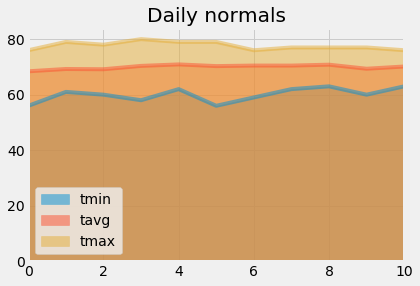

In [69]:
# Plot the daily normals as an area plot with `stacked=False`

normalsPD.plot(kind="area", stacked=False, title= "Daily normals")
